# Twitter Sentiment Analysis for Grenoble Data Science Meet-up
**Author**: Georgios Balikas, *January 10, 2018*


The notebook contains the code used to perform the feature extraction and model selection steps that are described in my meet-up presentation. 

The cells describe a machine learning pipeline where one:
1. Loads the data
2. Performs feature extraction using basically the bag-of-words representation
3. Some feature engineering
4. Performance evaluation using linear model (Logistic Regression and SVMs)

In terms of evaluation I decided to report the macro-averaged $F_1$ measure because I wanted to motivate performing well to across all classes (including the rare ones). Of course,  adpting the code to report more measures or even optimizing for other measures is very simple and encouraged. 

In [16]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn, re
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pd.options.display.max_colwidth = 200
from sklearn.metrics import f1_score


We will use the data released in the context of Task 4 of the SemEval 2017 challenges. 

More details for the task are at: http://alt.qcri.org/semeval2017/task4/

The data can be downloaded at https://www.dropbox.com/s/qqvokdtalf0kgs2/2017_English_final.zip

By downloading the data you confirm respecting the Twitter Terms of use, as they are also described by the SemEval Task 4 organisers. 

That said, let's start by loading and doing some basic data exploration.


## Load training data and perform some exploratory analysis

In [3]:
train_data = pd.read_csv("./2017_English_final/GOLD/Subtasks_CE/twitter-2016train-CE.txt", sep="\t+", encoding="utf8", 
                          names=["id", "topic", "score", "text"], )
print("Data loaded. Shape:", train_data.shape)
x_train_text = train_data.text.values # will be used for feature extraction and engineering later.
y_train = train_data.score.values # These are the categories that we will try to predict. 

('Data loaded. Shape:', (6000, 4))


/home/ama/balikas/balikasENV/lib/python2.7/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


Let's print the first columns of the dataframe to see how the data look.

In [4]:
train_data.head(5)

,id,topic,score,text
0,628949369883000832,@microsoft,-1,"dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."
1,628976607420645377,@microsoft,-2,@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!
2,629023169169518592,@microsoft,-1,I may be ignorant on this issue but... should we celebrate @Microsoft's parental leave changes? Doesn't the gender divide suggest... (1/2)
3,629179223232479232,@microsoft,-1,"Thanks to @microsoft, I just may be switching over to @apple."
4,629186282179153920,@microsoft,0,If I make a game as a #windows10 Universal App. Will #xboxone owners be able to download and play it in November? @majornelson @Microsoft


The fields are rather self-explaining. For the puproses of this notebook we will use the content of "text" and "score" columns. The "topic" column is very interesting for the task of quantification, that I will try to cover in another notebook.

In [5]:
# Lets count the different number of topics
train_data.topic.nunique()

60

In [6]:
# Verify that we are in a five-scale case
train_data.score.nunique(),  train_data.score.unique()

(5, array([-1, -2,  0,  1,  2]))

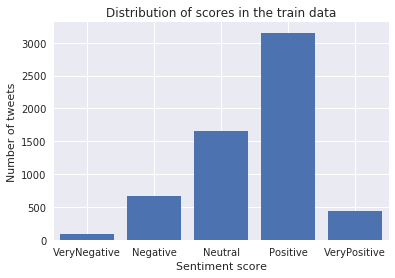

In [8]:
# plot the distribution of the scores across the dataset
stats = Counter(train_data.score.values)
plt.bar(stats.keys(), stats.values())
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")
plt.title("Distribution of scores in the train data")
plt.xticks(range(-2,3), ["VeryNegative", "Negative", "Neutral", "Positive", "VeryPositive"])
plt.xlim([-2.5,2.5])
plt.savefig("figures/score_distribution_training.svg")

As we can see in the data, most of the tweets are positive in terms of the sentiment they convey. This suggests that predicting positive for each tweets can be one of our baselines. 

Let's move on by visualizing the different sentiment polarities for each of the topics. To this end, we will find the topics that have mostly negative or positive tweets and visualize this distribution.

In [9]:
train_data.groupby("topic").agg({"score":["mean", "std"]}).reset_index().sort_values(("score", "mean")).head(3)

topic score          
              mean       std
25   erdogan -0.61  0.649709
45  jeb bush -0.53  0.610597
37   hillary -0.35  0.957427

Lets visualize the distributions for these three, negative topics:

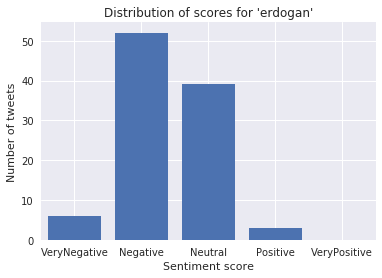

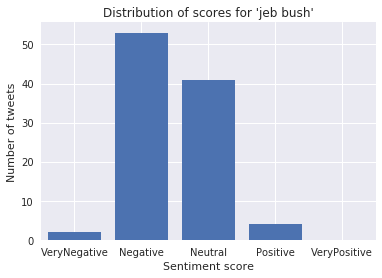

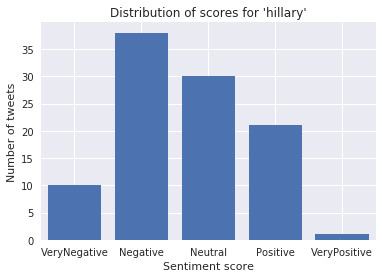

In [10]:
for _topic in ["erdogan", "jeb bush", "hillary"]:
    plt.figure()
    stats = Counter(train_data[train_data.topic == _topic].score.values)
    plt.bar(stats.keys(), stats.values())
    plt.xlabel("Sentiment score")
    plt.ylabel("Number of tweets")
    plt.title("Distribution of scores for '%s'"%_topic)
    plt.xticks(range(-2,3), ["VeryNegative", "Negative", "Neutral", "Positive", "VeryPositive"])
    plt.xlim([-2.5,2.5])
    plt.savefig("negative_%s.svg"%_topic)

We repeat the same process for the most positive topics.. We first identify them and then visualize the sentiment distributions.

In [12]:
train_data.groupby("topic").agg({"score":["mean", "std"]}).reset_index().sort_values(("score", "mean"), ascending=False).head(3)

topic score          
                    mean       std
1            ac/dc  1.16  0.662411
56  magic mike xxl  1.10  0.659047
15      bob marley  1.03  0.610597

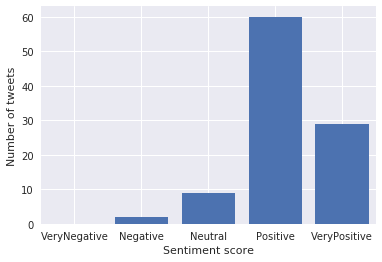

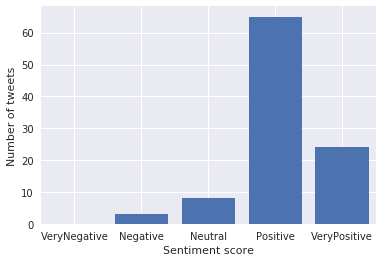

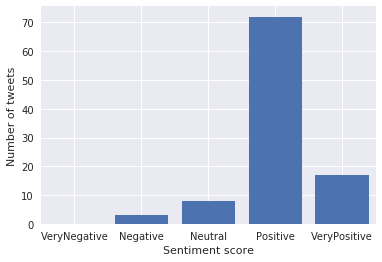

In [13]:
for filename, _topic in zip(["ac_dc", "magic_mike_xxl", "bob_marley"], ["ac/dc", "magic mike xxl", "bob marley"]):
    plt.figure()
    stats = Counter(train_data[train_data.topic == _topic].score.values)
    plt.bar(stats.keys(), stats.values())
    plt.xlabel("Sentiment score")
    plt.ylabel("Number of tweets")
    plt.xticks(range(-2,3), ["VeryNegative", "Negative", "Neutral", "Positive", "VeryPositive"])
    plt.xlim([-2.5,2.5])
    plt.savefig("positive_%s.svg"%filename)

## Load test data and start by evaluating a dumb classifier. 

In [15]:
# Let's repeat the loading process with the test data.
# Remember, we use the test data ONLY for evalution avoiding any type of ovefitting them.
test_data = pd.read_csv("./2017_English_final/GOLD/Subtasks_CE/twitter-2016dev-CE.txt", sep="\t+", encoding="utf8", 
                          names=["id", "topic", "score", "text"], )
test_text, y_test = test_data.text.values, test_data.score.values

/home/ama/balikas/balikasENV/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Let's start by some out-of-the box systems
1. Majority class
2. CountVectorizer+Logistic Regression

For simplicity we will report only one score, that is the score of the $F_1$ evaluation measure. More information for the f-score is available at https://en.wikipedia.org/wiki/F1_score. 
In our problem here we will report macro-averaged $F_1$ score, because we want to penalize our models if they only perform well on the majority classes. 

In [18]:
# We noticed that Positive is the majority class, so we evaluate a super-simple system that always predicts 1.
print("Score of the majority baseline:", f1_score(y_test, np.ones(len(test_text)), average="macro"))

('Score of the majority baseline:', 0.12724173201500172)


In [22]:
# If we want to see how the system performs for each of the classes: 
print("Analysis if the baseline performance:", f1_score(y_test, np.ones(len(test_text)), average=None))
# Notice that for the Positive we are doing quite well! 
# Also, to better understand macro-averaging notice that 0.6362/5=0.1272.. (our previous score!)

('Analysis if the baseline performance:', array([ 0.        ,  0.        ,  0.        ,  0.63620866,  0.        ]))


## Building a standard text classifier using bag-of-words representation 

As said, a few steps are necessary: 
1. from text to vectors: tokenisation (split in words) + bag-of-words
2. model selection: tune the free parameters of the model (e.g., the $C$ of SVM or Logistic Regression)
3. evaluation: after model selection, transform the test data and report MaF$_1$ (macro-F$_1$ measure) 

We will start adapting our approach now for twitter data. 
We will start by using a custom tokenizer, where we will:
    - normalize urls -> @url
    - normalize mentions e.g., @balikasg -> @user
    - do not lowercase emoticons, e.g., :-D remains :-D
To achieve that we will write a tokenizer function to pass it at CountVectorizer/TfIdfVectorizer etc.

In [24]:
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
twitter_tokenizer = TweetTokenizer()


def my_tokenizer(tweet, tokenizer = twitter_tokenizer, lowercase=True):
    """
    Performs the tokenzation step. Adapted for Twitter.
    Inputs
    ------
    tweet: string. A tweet to be tokenized.
    tokenizer: a model that can tokenize text. Check nltk tokenizers for example (from nltk.tokenize import TweetTokenizer).
    lowercase (default = True): if True, lowercse the words.
    Returns
    -------
    A list of the words that appear in the tweet. 
    """
    tweet = re.sub(r"(?:@[\w_]+)", 'user', tweet, flags= re.UNICODE) #mentions
    tweet = re.sub(r'http\S+', "url", tweet, flags= re.UNICODE) #urls
    tweet = re.sub(r"\b(?:never|no|nothing|nowhere|noone|none|not|havent|haven't|hasnt|hasn't|hadnt|hadn't|cant|can't|couldnt|couldn't|shouldnt|shouldn't|wont|won't|wouldnt|wouldn't|dont|don't|doesnt|doesn't|didnt|didn't|isnt|isn't|arent|aren't|aint|ain't)\b[\w\s]+[.,:;!?]", 
       lambda match: re.sub(r'(\s+)(\w+)', r'\1\2_NEG', match.group(0)),tweet, flags=re.IGNORECASE) # spot negative context
    words = tokenizer.tokenize(tweet) # split in words 
    if lowercase: # if true, lowercase words
        words = map((lambda x :  x.lower()), words) # lowervase words
        words = list(words)
    return words # return the words of tweets as a list
    

In [26]:
def get_grid_search_score(x_train, y_train, x_test, y_test, c_values = [0.1, 1, 10, 100], class_weight="balanced"):
    """
    Reports the MaF1 measure for Logistic Regression and SVM on the given data.
    Performs grid search for the C value of SVMs and Logistic Regression. 
    The search is done using 3-fold stratified cross-validation. 
    Inputs
    ------
    x_train: np.array. Vectorized training data
    y_train: np.array. The classes (categories) of each of the training instances
    x_test: np.array. Vectorized test data
    y_test: np.array. The classes (categories) of each of the test instances. Used for calculating MaF1 score
    c_values (default: [0.1, 1, 10, 100]): list. The list of C values to be used for model selection
    class_weight (default: "balanced"): None/"balanced" Whether to add class weights when optimizing the loss of the learner.
    
    Returns
    -------
    None.
    It prints the score of the optimized model on the test data.
    """
    for model_name, clf in zip(["Logistic Regression", "SVM"],[LogisticRegression(class_weight=class_weight), LinearSVC(class_weight=class_weight)]):
        gs = GridSearchCV(clf, {"C":c_values}, scoring="f1_macro",n_jobs=-1, cv=3)
        gs.fit(x_train, y_train)
        preds = gs.predict(x_test)
        print("Score of %s:"%model_name, f1_score(y_test, preds, average="macro"))


## Let's start without class weights

In the following, we will evaluate a CountVectorizer with and without class weights. This is the simplest way to approach a text classification problem, and will be our realistic baseline!

In [16]:
vectorizer = CountVectorizer(ngram_range=(1,1), tokenizer=my_tokenizer)
x_train = vectorizer.fit_transform(x_train_text) # We (always) fit on the train part, 

# x_train = vectorizer.fit(x_train_text + test_text) # Fitting on their concatenation
#is problematic as it assumes access to data you don't really have during the trainign phase.

x_test = vectorizer.transform(test_text) # and predict on the test part of our data.

x_train = normalize(x_train) #L2 per-row nomarlization
x_test = normalize(x_test)

print("Scores without class weights (uniform)")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight=None)
print("\nScores with class weights")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")


Scores without class weights (uniform)
('Score of Logistic Regression:', 0.26693093874193219)
('Score of SVM:', 0.26988237890323291)

Scores with class weights
('Score of Logistic Regression:', 0.28810193907769349)
('Score of SVM:', 0.29252164748039899)


By just using the CountVectorizer we have observed a dramatic improvement over our dummy baseline.

What if we simply weight the words using the idf scheme?

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), tokenizer=my_tokenizer)
x_train = vectorizer.fit_transform(train_data.text.values)
x_test = vectorizer.transform(test_text)

x_train = normalize(x_train)
x_test = normalize(x_test)

print("Scores without class weights (uniform)")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight=None)
print("\nScores with class weights")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")


Scores without class weights (uniform)
('Score of Logistic Regression:', 0.26072709581837311)
('Score of SVM:', 0.26277752047881836)

Scores with class weights
('Score of Logistic Regression:', 0.3193118676355019)
('Score of SVM:', 0.30317475325161281)


Ok, some minor improvements are observed when using the idf scheme, not at all bad when we just modified a simple line of code. 

Twitter however can be challenging due to the creative ways people use to express themselves in a few hunderds of characters. Let's start exploring subword information and, in particular, characer grams..

In the next two cell we will repeat the process by building vector representations using characters grams of length from 3 letters untill 6 letters. We first run the code on simple counts (Countvectorizer) and then we also apply the idf weighting scheme.

In [18]:
vectorizer = CountVectorizer(ngram_range=(3,6), analyzer="char",  tokenizer=my_tokenizer)
x_train = vectorizer.fit_transform(train_data.text.values)
x_test = vectorizer.transform(test_text)


x_train = normalize(x_train)
x_test = normalize(x_test)

print("Scores without class weights (uniform)")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight=None)
print("\nScores with class weights")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")


Scores without class weights (uniform)
('Score of Logistic Regression:', 0.30316913415193208)
('Score of SVM:', 0.30011137465070614)

Scores with class weights
('Score of Logistic Regression:', 0.30716422545900252)
('Score of SVM:', 0.30939877625071605)


In [19]:
vectorizer = TfidfVectorizer(ngram_range=(3,6), analyzer="char",  tokenizer=my_tokenizer)
x_train = vectorizer.fit_transform(train_data.text.values)
x_test = vectorizer.transform(test_text)

x_train = normalize(x_train)
x_test = normalize(x_test)

print("Scores without class weights (uniform)")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight=None)
print("\nScores with class weights")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")



Scores without class weights (uniform)
('Score of Logistic Regression:', 0.28345953744599578)
('Score of SVM:', 0.30440115323798517)

Scores with class weights
('Score of Logistic Regression:', 0.30987685014266819)
('Score of SVM:', 0.31325753937887335)


## We have explored basic word features, now compile more features

1. exclamation marks
2. question marks
2. question and exclamation marks
2. positive emoticons
2. negative emoticons
2. Fully capitalized words (GREAT)
2. elongated words, loooong
2. words in negative contexts

The functions below implement those features.

In [28]:
def allCaps(words):
    """ Input: list of words, Output: how many are all caps """
    return len([word for word in words if word.isupper()])

def elongated(words):
    """ Input: list of words, Output: how many are elongated """
    return len([word for word in words if re.search(r"(.)\1{2}", word.lower())])

def exclamations(tweet):
    """ Input: a tweet, Output: how many exclamations """
    return len(re.findall("!+", tweet))

def questions(tweet):
    """ Input: a tweet, Output: how many question marks """
    return len(re.findall("\?+", tweet))

def questions_and_exclamation(tweet):
    """ Input: a tweet, Output: how many question marks and exclamation marks"""
    return len(re.findall("[\?,!]+", tweet))

def words_in_neg_context(words):
    """ Input: list of words, Output: how many are elongated """
    return len([word for word in words if word.endswith("_NEG")])

def emoticon_positive(tweet):
    """ Input: a tweet, Output: (binary) positive emoticons exist """
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]dD\}@]                # mouth      
      |                          # reverse order now! 
      [\)\]dD\}@]                # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    emoticon_re = re.compile(emoticon_string, re.VERBOSE | re.I | re.UNICODE)
    return len(emoticon_re.findall(tweet)) > 0

def emoticon_negative(tweet):
    """ Input: a tweet, Output: (binary) negative emoticons exist """
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\(\[pP/\:\{\|] # mouth      
      |                          # reverse order now! 
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    emoticon_re = re.compile(emoticon_string, re.VERBOSE | re.I | re.UNICODE)
    return len(emoticon_re.findall(tweet)) > 0


def getBingLiusCounters(positive, negative, tokenized_tweet):
    """
    Uses the bing lius sentiment lexicons and calculates several counts..
    The lexicon is available at: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
    """
    positive_words_pos_context = len([w for w in tokenized_tweet if w in positive_words])
    negative_words_pos_context = len([w for w in tokenized_tweet if w in negative_words])
    positive_words_uppercase = len([w for w in tokenized_tweet if w.lower() in positive_words and w.isupper()])
    negative_words_uppercase = len([w for w in tokenized_tweet if w.lower() in negative_words and w.isupper()])
    positive_words_hashtags = len([w for w in tokenized_tweet if w[1:] in positive_words and w.startswith("#")])
    negative_words_hashtags = len([w for w in tokenized_tweet if w[1:] in negative_words and w.startswith("#")])
    positive_words_hashtags_upper = len([w for w in tokenized_tweet if w[1:] in positive_words and w.startswith("#") and w.isupper()])
    negative_words_hashtags_upper = len([w for w in tokenized_tweet if w[1:] in negative_words and w.startswith("#") and w.isupper()])
    
    positive_words_neg_context = len([w for w in tokenized_tweet if w[:-4] in positive_words and w.endswith("_NEG")])
    negative_words_neg_context = len([w for w in tokenized_tweet if w.strip("_NEG") in negative_words and w.endswith("_NEG")])
    # more things can be added here but the point is made
    
    return [positive_words_pos_context, negative_words_pos_context, positive_words_uppercase, negative_words_uppercase, \
            positive_words_hashtags, negative_words_hashtags, positive_words_hashtags_upper, negative_words_hashtags_upper, \
            positive_words_neg_context, negative_words_neg_context]


In [21]:
# Load the positive and negative words, downloaded from Bing Lius website: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
positive_words = set(open("./lexicons/bing_liu/positive-words_bing_liu.txt").read().splitlines())
negative_words = set(open("./lexicons/bing_liu/negative-words_bing_liu.txt").read().splitlines())


In [23]:
def get_handmade_features(tweet):
    """
    Returns for a tweet the hand-designed features.
    Inputs
    ------
    tweet: string. The tweet to be tokenized
    Returns:
    features: list. A list of handmade features
    """
    tokens = my_tokenizer(tweet, lowercase = False)    
    bing_lius = getBingLiusCounters(positive_words, negative_words, tokens)
    return [words_in_neg_context(tokens), allCaps(tokens), elongated(tokens), exclamations(tweet), questions(tweet), questions_and_exclamation(tweet),
           int(emoticon_positive(tweet)), int(emoticon_negative(tweet))] +bing_lius

special_features_train = np.array([get_handmade_features(tweet) for tweet in train_data.text.values])
special_features_test = np.array([get_handmade_features(tweet) for tweet in test_data.text.values])


Ok.. to this point we saw an example of a lexicon, and examples of several manually designed features. 
We can now move by doing part of Speech tagging to obtain the POS tags of each word in out tweet. 
There are several tools for this, me favourity is spacy, which is extremely fast and accurate. 

In [24]:
import spacy
nlp = spacy.load('en', disable=['parser',  'ner'])
pos_tags_train = [[token.pos_ for token in nlp(unicode(tweet))] for tweet in train_data.text.values]
pos_tags_test = [[token.pos_ for token in nlp(unicode(tweet))] for tweet in test_data.text.values]
different_pos_tags = ["ADJ", "NOUN", "VERB"]
pos_distribution_train, pos_distribution_test = [], []
for pos_of_tweet in pos_tags_train:
    pos_distribution_train.append( [pos_of_tweet.count(x) for x in different_pos_tags])
    
for pos_of_tweet in pos_tags_test:
    pos_distribution_test.append( [pos_of_tweet.count(x) for x in different_pos_tags])


Having the feature extraction functions in place, let's see what the new features bring!

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(3,6), analyzer="char", tokenizer=my_tokenizer,)
x_train = vectorizer.fit_transform(train_data.text.values)
x_test = vectorizer.transform(test_text)

x_train =  hstack((x_train, special_features_train, pos_distribution_train))
x_test = hstack((x_test, special_features_test, pos_distribution_test))
x_train = normalize(x_train)
x_test = normalize(x_test)

print("Scores without class weights (uniform)")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight=None)
print("\nScores with class weights")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")


Scores without class weights (uniform)
('Score of Logistic Regression:', 0.26259602433447993)
('Score of SVM:', 0.29399379633858708)

Scores with class weights
('Score of Logistic Regression:', 0.33626631439811411)
('Score of SVM:', 0.32399301052666141)


In [26]:
# The number "features" below ashould be grid-searched. Here, we are using for simplicity a number found with trial/error 
features = 19000
vectorizer = TfidfVectorizer(ngram_range=(3,6), analyzer="char", tokenizer=my_tokenizer, max_features=features)
x_train_uni = vectorizer.fit_transform(train_data.text.values)
x_test_uni = vectorizer.transform(test_text)

vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=my_tokenizer, max_features=features)
x_train_char = vectorizer.fit_transform(train_data.text.values)
x_test_char = vectorizer.transform(test_text)

x_train =  normalize(hstack((x_train_uni, x_train_char, special_features_train, pos_distribution_train)))
x_test = normalize(hstack((x_test_uni, x_test_char, special_features_test, pos_distribution_test)))

get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")
    

('Score of Logistic Regression:', 0.3235947420014707)
('Score of SVM:', 0.32711297492942931)


Yeahhh! Better!

Not bad at all! Great Improvement with a small (programmatic) effort! We can definitely do better on this step, and add much more features.. But the point is just to demonstrate the rationale here..


# An approach powered by word embeddings

Word embeddings are considered a good practise for most of the NLP problems. In the next few lines of code, we are exploring how FastText embeddings perform on the task. 

More information on the FastText embeddings and how they are learned can be found at: https://fasttext.cc/

To load and process them we will use Gensim, which offers convenient functionality for this purpose and can be used (out-of-the-box) with various embeddings (those of the w2v tool, Glove, FastText..)

In [27]:
from gensim.models.wrappers import FastText
model = FastText.load_fasttext_format("./wiki.en.bin")

In [28]:
# From now-on we will be using TwitterTokenizer, to avoid adding _NEG
def my_tokenizer(tweet, tokenizer = twitter_tokenizer, lowercase=True):
    tweet = re.sub(r"(?:@[\w_]+)", 'user', tweet, flags= re.UNICODE) #mentions
    tweet = re.sub(r'http\S+', "url", tweet, flags= re.UNICODE) #urls
    words = tokenizer.tokenize(tweet)
    if lowercase:
        words = map((lambda x :  x.lower()), words) # lowervase words
        words = list(words)
    return words

In [30]:
def tweet_embedding(model, tweet ):
    """
    Returns the tweet representation, as the average of the vectors of the words of the tweet.
    Inputs
    ------
    model: dictionary or Gensim model. Association of words to their embeddings
    tweet: string. Tweet to be tokenized
    
    Returns
    -------
    np.array: the tweet representation
    """
    tokens = my_tokenizer(tweet)
    representation = []
    for token in tokens:
        try:
            representation.append(model[token])
        except:
            pass 
    if len(representation):
        return np.average(representation, axis=0)
    else:
        return np.zeros(300)

    
def tweet_embedding_only_voc(model, tweet ):
    """
    Returns the tweet representation, as the average of the vectors of the words of the tweet.
    Specific function for FastText, that disables predicting word embeddings from character-ngrams. 
    Inputs
    ------
    model: dictionary or Gensim model. Association of words to their embeddings
    tweet: string. Tweet to be tokenized
    
    Returns
    -------
    np.array: the tweet representation
    """
    tokens = my_tokenizer(tweet)
    representation = []
    for token in tokens:
        if token in model.wv.vocab:
            representation.append(model[token])
    if len(representation):
        return np.average(representation, axis=0)
    else:
        return np.zeros(300)


In [31]:
# Let's obtain the embedding representation of the tweets
train_emb = np.array([tweet_embedding(model, tweet ) for tweet in train_data.text.values])
test_emb = np.array([tweet_embedding(model, tweet) for tweet in  test_text])

/home/ama/balikas/balikasENV/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [32]:
#Let's test them! Here FastText predicts embeddings for OOV
get_grid_search_score(train_emb, y_train, test_emb, y_test, class_weight=None)
get_grid_search_score(train_emb, y_train, test_emb, y_test, class_weight="balanced")

('Score of Logistic Regression:', 0.32274493354732831)
('Score of SVM:', 0.26810722578194601)
('Score of Logistic Regression:', 0.34533590419795257)
('Score of SVM:', 0.33583568598928293)


In [33]:
#Let's obtain the embedding representation of the tweets without the default FastText behaviour of OOV
train_emb = np.array([tweet_embedding_only_voc(model, tweet,) for tweet in train_data.text.values])
test_emb = np.array([tweet_embedding_only_voc(model, tweet, ) for tweet in  test_text])

/home/ama/balikas/balikasENV/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [34]:
get_grid_search_score(train_emb, y_train, test_emb, y_test, class_weight=None)
get_grid_search_score(train_emb, y_train, test_emb, y_test, class_weight="balanced")

('Score of Logistic Regression:', 0.30740812851201932)
('Score of SVM:', 0.31134490003179061)
('Score of Logistic Regression:', 0.3614991122414703)
('Score of SVM:', 0.35504169694061771)


This is a striking result to me.. Disabling OOV embeddings prediction actually improved the result a lot. Need to better see why this is happening. 

Notice however tha for both cases, embeddings performed much better than bag-of-words! Hence, it is an adviced approach for the problem. 

Now, to conclude, let's test whether by combining both worlds we gain something! 

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=my_tokenizer)
x_train = vectorizer.fit_transform(train_data.text.values)
x_test = vectorizer.transform(test_text)

x_train =  hstack((x_train,  train_emb))
x_test = hstack((x_test, test_emb))
x_train = normalize(x_train)
x_test = normalize(x_test)

print("\nScores with class weights")
get_grid_search_score(x_train, y_train, x_test, y_test, class_weight="balanced")



Scores with class weights
('Score of Logistic Regression:', 0.37469022993670659)
('Score of SVM:', 0.37137153666242406)


As in most cases, combining both worlds is beneficial! 

There can be several extensions of this work: 
1. Add special features to embeddings
2. Try other types of embeddings
3. Try other ways of learning the embedding of a tweet. These are called compositional functions. Here we used averaging for this purpose but one can come up we more/better approaches
4. Try other learning methods.. Neural Nets, Trees...
5. Examine how the above described steps behave when optimizing a nother measure like Accuracy, Micro-F-Measure etc. 

## References

- S. Kiritchenko,  X. Zhu and S. Mohammad: Sentiment analysis of short informal texts. JAIR, 2014
- G. Balikas and MR Amini: TwiSE at SemEval-2016 Task 4: Twitter Sentiment Classification, SemEval, 2016
- G. Balikas, S. Moura, MR Amini: Multitask Learning for Fine-Grained Twitter Sentiment Analysis, SIGIR, 2016
- A. Radford, R. Jozefowicz, I. Sutskever: Learning to generate reviews and discovering sentiment, Arxiv, 2017
- W. Gao, F. Sebastiani: Tweet sentiment: From classification to quantification, ASONAM, 2015
- S. Rosenthal, N. Farra, P. Nakov: SemEval-2017 task 4: Sentiment analysis in Twitter